# **Single Step**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Flatten
from datetime import timedelta


In [ ]:
# Load the dataset (Update the path if needed)
file_path = "/content/weatherHistory.csv"
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

# Check column names
print(df.columns)


                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13  

In [ ]:
# Convert 'Formatted Date' to datetime and remove timezone
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True).dt.tz_localize(None)
df.set_index('Formatted Date', inplace=True)


In [ ]:
# Selecting relevant features (Adding 'Daily Summary' for text-based predictions)
df = df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)', 'Daily Summary']]


In [ ]:

# Separate numerical and text columns
numerical_columns = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
text_column = 'Daily Summary'

# Fill missing values for numerical columns with the column mean
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())

# Fill missing values for text column with the most frequent category
df[text_column] = df[text_column].fillna(df[text_column].mode()[0])

# Encode 'Daily Summary' into numerical labels
label_encoder = LabelEncoder()
df['Daily Summary Encoded'] = label_encoder.fit_transform(df['Daily Summary'])

# Drop original text column since we now have the encoded version
df.drop(columns=['Daily Summary'], inplace=True)

# Normalize numerical data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Display first few rows
df_scaled.head()


,Temperature (C),Humidity,Wind Speed (km/h),Pressure (millibars),Daily Summary Encoded
Formatted Date,,,,,
2006-03-31 22:00:00,0.506975,0.89,0.221130,0.970135,0.924883
2006-03-31 23:00:00,0.505085,0.86,0.223399,0.970613,0.924883
2006-04-01 00:00:00,0.505445,0.89,0.061523,0.970909,0.924883
2006-04-01 01:00:00,0.487805,0.83,0.220877,0.971358,0.924883
2006-04-01 02:00:00,0.495365,0.83,0.172970,0.971454,0.924883


In [ ]:
def create_sequences_multivariate(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])  # Predicting all features
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Create sequences for multi-variable prediction
X, y = create_sequences_multivariate(scaled_data, sequence_length)


In [ ]:
# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print shape
print(X_train.shape, y_train.shape)


(77154, 10, 5) (77154, 5)


In [ ]:
# Define the GRU model
model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, activation='relu'),
    Dropout(0.2),
    Dense(5)  # Output 5 values: Temperature, Humidity, Wind Speed, Pressure, Summary Label
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2412/2412 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 0.0473 - mae: 0.1444 - val_loss: 0.0034 - val_mae: 0.0365
Epoch 2/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0088 - mae: 0.0639 - val_loss: 0.0028 - val_mae: 0.0318
Epoch 3/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0067 - mae: 0.0519 - val_loss: 0.0026 - val_mae: 0.0283
Epoch 4/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0061 - mae: 0.0481 - val_loss: 0.0026 - val_mae: 0.0310
Epoch 5/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0059 - mae: 0.0466 - val_loss: 0.0027 - val_mae: 0.0297
Epoch 6/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.0058 - mae: 0.0457 - val_loss: 0.0024 - val_mae: 0.0275
Epoch 7/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0057 - mae: 0.0449 - val_loss: 0.0025 - val_mae: 0.0289
Epoch 8/20
2412/2412 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0056 - mae: 0.0445 - val_loss: 0.0024 - val_mae: 0.0292
Epoch 9/20
2412/2412 ━━━━━━━━━━━━━━

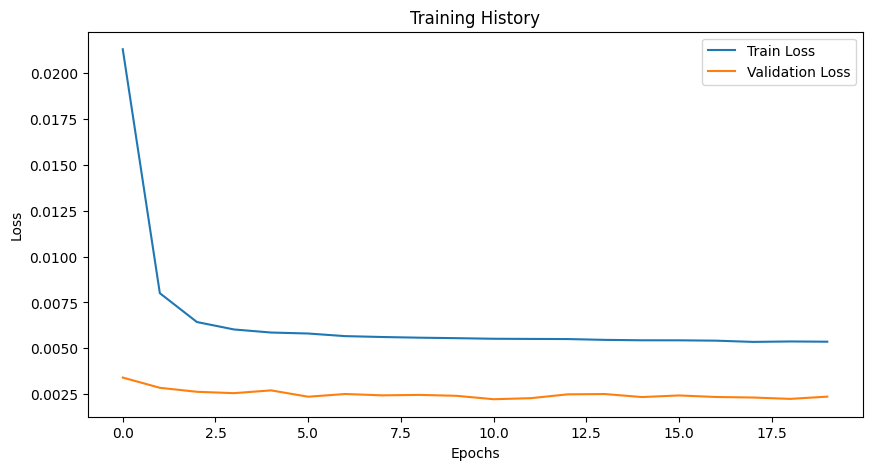

In [ ]:
# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Convert predicted Daily Summary values to integers
predicted_labels = y_pred_rescaled[:, 4].astype(int)

# Ensure labels are within known range
num_classes = len(label_encoder.classes_)
predicted_labels = np.clip(predicted_labels, 0, num_classes - 1)  # Restrict to valid range

# Convert back to text labels
predicted_summaries = label_encoder.inverse_transform(predicted_labels)


# Calculate performance metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


603/603 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Mean Absolute Error (MAE): 4.50
Mean Squared Error (MSE): 485.92
Root Mean Squared Error (RMSE): 22.04
R² Score: 0.8459


In [ ]:
# Generate future timestamps
future_dates = [df.index[-1] + timedelta(hours=i) for i in range(1, len(y_pred_rescaled) + 1)]

# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted Temperature (C)': y_pred_rescaled[:, 0],
    'Predicted Humidity (%)': y_pred_rescaled[:, 1],
    'Predicted Wind Speed (km/h)': y_pred_rescaled[:, 2],
    'Predicted Pressure (millibars)': y_pred_rescaled[:, 3],
    'Predicted Daily Summary': predicted_labels
})

# Display first few predictions
print(predictions_df.head())


             DateTime  Predicted Temperature (C)  Predicted Humidity (%)  \
0 2016-09-09 22:00:00                   0.454390                0.922358   
1 2016-09-09 23:00:00                   0.937052                0.935252   
2 2016-09-10 00:00:00                   1.488997                0.935192   
3 2016-09-10 01:00:00                   2.438153                0.917663   
4 2016-09-10 02:00:00                   2.966003                0.887496   

   Predicted Wind Speed (km/h)  Predicted Pressure (millibars)  \
0                     4.903278                     1012.843994   
1                     4.575133                     1011.276428   
2                     5.030396                     1010.919373   
3                     5.468688                     1011.443237   
4                     7.115341                     1011.602966   

   Predicted Daily Summary  
0                       57  
1                       57  
2                       56  
3                       57  
4

In [ ]:
for i in range(10):  # Generate forecast for the next 10 time steps
    date_time = predictions_df.iloc[i]['DateTime']
    temp = predictions_df.iloc[i]['Predicted Temperature (C)']
    humidity = predictions_df.iloc[i]['Predicted Humidity (%)']
    wind_speed = predictions_df.iloc[i]['Predicted Wind Speed (km/h)']
    pressure = predictions_df.iloc[i]['Predicted Pressure (millibars)']
    daily_summary = predictions_df.iloc[i]['Predicted Daily Summary']

    print(f"📅 {date_time.strftime('%Y-%m-%d %H:%M:%S')} - "
          f"🌡 Temperature: {temp:.2f}°C, "
          f"💧 Humidity: {humidity:.2f}%, "
          f"🌬 Wind Speed: {wind_speed:.2f} km/h, "
          f"⚖ Pressure: {pressure:.2f} millibars, "
          f"📝 Forecast Summary: {daily_summary}.")


📅 2016-09-09 22:00:00 - 🌡 Temperature: 0.45°C, 💧 Humidity: 0.92%, 🌬 Wind Speed: 4.90 km/h, ⚖ Pressure: 1012.84 millibars, 📝 Forecast Summary: 57.
📅 2016-09-09 23:00:00 - 🌡 Temperature: 0.94°C, 💧 Humidity: 0.94%, 🌬 Wind Speed: 4.58 km/h, ⚖ Pressure: 1011.28 millibars, 📝 Forecast Summary: 57.
📅 2016-09-10 00:00:00 - 🌡 Temperature: 1.49°C, 💧 Humidity: 0.94%, 🌬 Wind Speed: 5.03 km/h, ⚖ Pressure: 1010.92 millibars, 📝 Forecast Summary: 56.
📅 2016-09-10 01:00:00 - 🌡 Temperature: 2.44°C, 💧 Humidity: 0.92%, 🌬 Wind Speed: 5.47 km/h, ⚖ Pressure: 1011.44 millibars, 📝 Forecast Summary: 57.
📅 2016-09-10 02:00:00 - 🌡 Temperature: 2.97°C, 💧 Humidity: 0.89%, 🌬 Wind Speed: 7.12 km/h, ⚖ Pressure: 1011.60 millibars, 📝 Forecast Summary: 58.
📅 2016-09-10 03:00:00 - 🌡 Temperature: 3.09°C, 💧 Humidity: 0.91%, 🌬 Wind Speed: 5.50 km/h, ⚖ Pressure: 1011.43 millibars, 📝 Forecast Summary: 57.
📅 2016-09-10 04:00:00 - 🌡 Temperature: 6.61°C, 💧 Humidity: 0.74%, 🌬 Wind Speed: 6.74 km/h, ⚖ Pressure: 1015.26 millibars, 📝 

In [ ]:
from IPython.display import display
display(predictions_df)


,DateTime,Predicted Temperature (C),Predicted Humidity (%),Predicted Wind Speed (km/h),Predicted Pressure (millibars),Predicted Daily Summary
0,2016-09-09 22:00:00,0.454390,0.922358,4.903278,1012.843994,Foggy starting overnight continuing until morn...
1,2016-09-09 23:00:00,0.937052,0.935252,4.575133,1011.276428,Foggy starting overnight continuing until morn...
2,2016-09-10 00:00:00,1.488997,0.935192,5.030396,1010.919373,Foggy starting overnight continuing until morn...
3,2016-09-10 01:00:00,2.438153,0.917663,5.468688,1011.443237,Foggy starting overnight continuing until morn...
4,2016-09-10 02:00:00,2.966003,0.887496,7.115341,1011.602966,Foggy starting overnight continuing until night.
...,...,...,...,...,...,...
19284,2018-11-22 10:00:00,27.720539,0.354480,11.316873,1009.422913,Partly cloudy starting in the morning continui...
19285,2018-11-22 11:00:00,23.222483,0.504397,8.812803,1009.284058,Partly cloudy starting in the morning continui...
19286,2018-11-22 12:00:00,21.189899,0.558903,8.599411,1008.672607,Partly cloudy starting in the morning continui...
19287,2018-11-22 13:00:00,19.480356,0.625970,7.596645,1008.475281,Partly cloudy starting in the morning and bree...


In [ ]:
print("y_pred shape:", y_pred.shape)  # Should be (samples, output_length, num_features)
print("y_test shape:", y_test.shape)  # Should be (samples, output_length, num_features)


y_pred shape: (19288, 25)
y_test shape: (19288, 5, 5)


In [ ]:
# Reshape if y_pred or y_test are not 3D
if len(y_pred.shape) == 2:  # If missing time steps dimension
    y_pred = y_pred.reshape(y_pred.shape[0], -1, 1)  # Reshape to (samples, output_length, 1)
if len(y_test.shape) == 2:
    y_test = y_test.reshape(y_test.shape[0], -1, 1)


In [ ]:
# Check shape before reshaping
print("Original y_pred shape:", y_pred.shape)  # Expected: (samples, output_length * num_features)

# Reshape y_pred to (samples, output_length, num_features)
num_features = X_test.shape[2]  # Get the number of features from X_test
output_length = y_pred.shape[1] // num_features  # Compute output length

y_pred = y_pred.reshape(-1, output_length, num_features)

# Print new shape
print("Fixed y_pred shape:", y_pred.shape)  # Should be (samples, output_length, num_features)


Original y_pred shape: (19288, 25, 1)
Fixed y_pred shape: (19288, 5, 5)


In [ ]:
# Flatten predictions before inverse transformation
y_pred_flat = y_pred.reshape(-1, num_features)
y_test_flat = y_test.reshape(-1, num_features)  # Ensure y_test matches

# Apply inverse transformation
y_pred_rescaled = scaler.inverse_transform(y_pred_flat)[:, 0]  # Extract temperature column
y_test_rescaled = scaler.inverse_transform(y_test_flat)[:, 0]


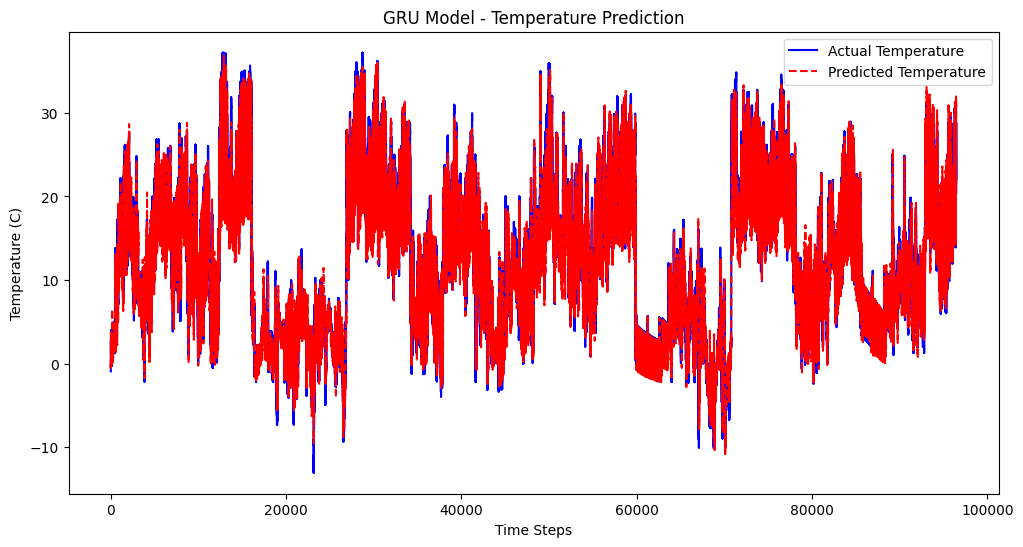

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Temperature", color='blue')  # Actual values in blue
plt.plot(y_pred_rescaled, label="Predicted Temperature", color='red', linestyle='dashed')  # Predictions in red dashed

# Add labels and title
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Temperature (C)")
plt.title("GRU Model - Temperature Prediction")

# Show the plot
plt.show()


# **Multi_Step**

In [ ]:
def create_multi_step_sequences(data, input_length=10, output_length=5):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i+input_length])  # Input: past `input_length` timesteps
        y.append(data[i+input_length:i+input_length+output_length])  # Output: next `output_length` timesteps
    return np.array(X), np.array(y)

# Define sequence lengths
input_length = 10   # Number of past time steps
output_length = 5   # Number of future time steps to predict

# Create sequences
X, y = create_multi_step_sequences(scaled_data, input_length, output_length)

# Print dataset shape
print("X shape:", X.shape)  # Expected: (num_samples, input_length, num_features)
print("y shape:", y.shape)  # Expected: (num_samples, output_length, num_features)


X shape: (96439, 10, 5)
y shape: (96439, 5, 5)


In [ ]:
# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print shapes
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (77151, 10, 5) (77151, 5, 5)
Testing set: (19288, 10, 5) (19288, 5, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model for multi-step forecasting
model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(input_length, X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(output_length * X_train.shape[2])  # Output all future steps at once
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=20, batch_size=32, validation_data=(X_test, y_test.reshape(y_test.shape[0], -1)))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2411/2411 ━━━━━━━━━━━━━━━━━━━━ 64s 24ms/step - loss: 0.0385 - mae: 0.1307 - val_loss: 0.0066 - val_mae: 0.0537
Epoch 2/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - loss: 0.0106 - mae: 0.0688 - val_loss: 0.0056 - val_mae: 0.0434
Epoch 3/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - loss: 0.0092 - mae: 0.0603 - val_loss: 0.0056 - val_mae: 0.0443
Epoch 4/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - loss: 0.0084 - mae: 0.0557 - val_loss: 0.0051 - val_mae: 0.0423
Epoch 5/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - loss: 0.0080 - mae: 0.0534 - val_loss: 0.0051 - val_mae: 0.0421
Epoch 6/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - loss: 0.0078 - mae: 0.0523 - val_loss: 0.0050 - val_mae: 0.0404
Epoch 7/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 79s 24ms/step - loss: 0.0077 - mae: 0.0518 - val_loss: 0.0049 - val_mae: 0.0407
Epoch 8/20
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0075 - mae: 0.0511 - val_loss: 0.0048 - val_mae: 0.0407
Epoch 9/20
2411/2411 ━━━━━━━━━━━━━━

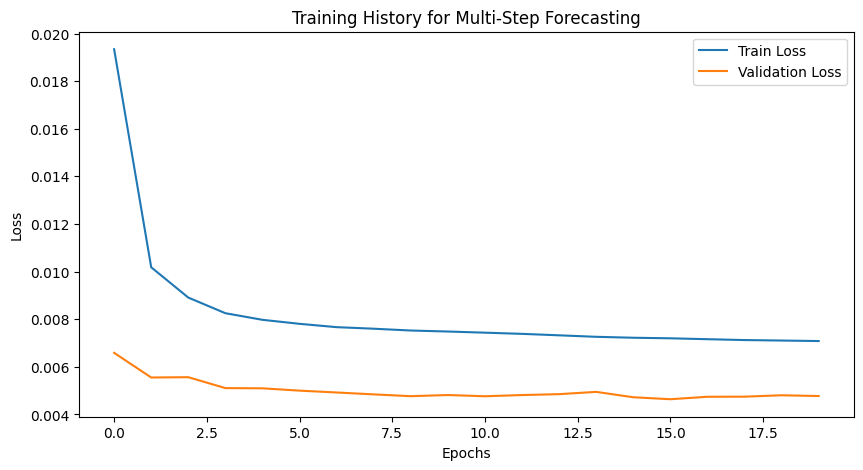

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History for Multi-Step Forecasting')
plt.show()


In [ ]:
# Make multi-step predictions
y_pred = model.predict(X_test)

# Reshape predictions to match the original format
y_pred = y_pred.reshape(y_test.shape)

# Inverse transform predictions to real values
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[2])).reshape(y_pred.shape)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2])).reshape(y_test.shape)

# Print shape to verify
print("Rescaled Predictions Shape:", y_pred_rescaled.shape)


603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Rescaled Predictions Shape: (19288, 5, 5)


In [ ]:
from datetime import timedelta
import pandas as pd

# Select one sample for demonstration
sample_index = 0  # Pick the first test sample
future_dates = [df.index[-1] + timedelta(hours=i+1) for i in range(output_length)]  # Generate future timestamps

# Convert predicted daily summaries back to text labels
predicted_labels = y_pred_rescaled[sample_index, :, 4].astype(int)
num_classes = len(label_encoder.classes_)
predicted_labels = np.clip(predicted_labels, 0, num_classes - 1)
predicted_summaries = label_encoder.inverse_transform(predicted_labels)

# Create DataFrame for multi-step predictions
multi_step_predictions = pd.DataFrame({
    'DateTime': future_dates,
    'Predicted Temperature (C)': y_pred_rescaled[sample_index, :, 0],
    'Predicted Humidity (%)': y_pred_rescaled[sample_index, :, 1],
    'Predicted Wind Speed (km/h)': y_pred_rescaled[sample_index, :, 2],
    'Predicted Pressure (millibars)': y_pred_rescaled[sample_index, :, 3],
    'Predicted Daily Summary': predicted_summaries
})

# Display the multi-step weather forecast in Google Colab
from IPython.display import display
display(multi_step_predictions)



,DateTime,Predicted Temperature (C),Predicted Humidity (%),Predicted Wind Speed (km/h),Predicted Pressure (millibars),Predicted Daily Summary
0,2016-09-09 22:00:00,-0.068086,0.951501,5.489783,1016.987366,Foggy starting overnight continuing until morn...
1,2016-09-09 23:00:00,-0.142916,0.949763,5.428885,989.912964,Foggy starting overnight continuing until morn...
2,2016-09-10 00:00:00,-0.255064,0.950678,5.808792,1012.968445,Foggy starting overnight continuing until morn...
3,2016-09-10 01:00:00,-0.118670,0.937000,5.808128,1001.992737,Foggy starting overnight continuing until morn...
4,2016-09-10 02:00:00,0.383163,0.929438,6.263308,1004.837769,Foggy starting overnight continuing until morn...
